# Controlled integrator

A controlled integrator is a circuit that acts on two signals:

1. Input - the signal being integrated
2. Control - the control signal to the integrator

A controlled integrator accumulates input,
but its state can be directly manipulated by the control signal.
We can write the dynamics of a simple controlled integrator like this:

$$
\dot{a}(t) = \mathrm{control}(t) \cdot a(t) + B \cdot \mathrm{input}(t)
$$

In this notebook, we will build a controlled intgrator with LIF neurons.
The Neural Engineering Framework (NEF) equivalent equation
for this integrator is:

$$
\dot{a}(t) = \mathrm{control}(t) \cdot a(t) + \tau \cdot \mathrm{input}(t).
$$

We call the coefficient $\tau$ here a *recurrent time constant*
because it governs the rate of integration.

Network behaviour:
`A = tau * Input + Input * Control`

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.processes import Piecewise

## Step 1: Create the network

We can use standard network-creation commands
to begin creating our controlled integrator.
We create a Network, and then we create
a population of neurons (called an *ensemble*).
This population of neurons will represent the state of our integrator,
and the connections between the neurons in the ensemble
will define the dynamics of our integrator.

In [2]:
model = nengo.Network(label='Controlled Integrator')
with model:
    # Make a population with 225 LIF neurons
    # representing a 2 dimensional signal,
    # with a larger radius to accommodate large inputs
    A = nengo.Ensemble(225, dimensions=2, radius=1.5)

## Step 2: Define the 'input' signal to integrate

We will be running 1 second of simulation time,
so we will use a Python function `input_func`
to define our input signal for real values of time `t` from 0 to 1.
We'll define our signal to be a step function using if-then-else code.
Our piecewise function sits at 0 until .2 seconds into the simulation,
then jumps up to 5, back to 0, down to -10, back to 0, then up to 5,
and then back to 0. Our integrator will respond by ramping up
when the input is positive, and descending when the input is negative.

In [3]:
with model:
    # Create a piecewise step function for input
    input_func = Piecewise({
        0: 0,
        0.2: 5,
        0.3: 0,
        0.44: -10,
        0.54: 0,
        0.8: 5,
        0.9: 0
    })

We include this input function (`input_func`)
into our neural model like this:

In [4]:
with model:
    # Define an input signal within our model
    inp = nengo.Node(input_func)

    # Connect the Input signal to ensemble A.
    # The `transform` argument means "connect real-valued signal
    # "Input" to the first of the two input channels of A."
    tau = 0.1
    nengo.Connection(inp, A, transform=[[tau], [0]], synapse=tau)

## Step 3: Define the 'control' signal

We also need to create a control signal
that controls how the integrator behaves.
We will make this signal 1 for the first part of the simulation,
and 0.5 for the second part.
This means that at the beginning of the simulation,
the integrator will act as an optimal integrator,
and partway though the simulation (at t = 0.6),
it will switch to being a leaky integrator.

In [5]:
with model:
    # Another piecewise step that changes half way through the run
    control_func = Piecewise({0: 1, 0.6: 0.5})

We add the control signal to the network
like we added the input signal,
but this time we connect it to
the second dimension of our neural population.

In [6]:
with model:
    control = nengo.Node(output=control_func)

    # Connect the "Control" signal to the second of A's two input channels.
    nengo.Connection(control, A[1], synapse=0.005)

## Step 4: Define the integrator dynamics

We set up integrator by connecting population 'A' to itself.
We set up feedback in the model to handle integration of the input.
The time constant $\tau$ on the recurrent weights affects
both the rate and accuracy of integration.
Try adjusting it and see what happens!

In [7]:
with model:
    # Create a recurrent connection that first takes the product
    # of both dimensions in A (i.e., the value times the control)
    # and then adds this back into the first dimension of A using
    # a transform
    nengo.Connection(
        A, A[0],  # -- transform converts function output to new state inputs
        function=lambda x: x[0] * x[1],  # -- function is applied first to A
        synapse=tau)

    # Record both dimensions of A
    A_probe = nengo.Probe(A, 'decoded_output', synapse=0.01)

In [8]:
with nengo.Simulator(model) as sim:  # Create a simulator
    sim.run(1.4)  # Run for 1.4 seconds

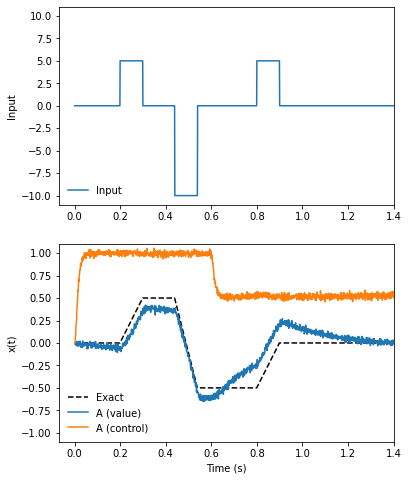

In [9]:
# Plot the value and control signals, along with the exact integral
t = sim.trange()
dt = t[1] - t[0]
input_sig = input_func.run(t[-1], dt=dt)
control_sig = control_func.run(t[-1], dt=dt)
ref = dt * np.cumsum(input_sig)

plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.plot(t, input_sig, label='Input')
plt.xlim(right=t[-1])
plt.ylim(-11, 11)
plt.ylabel('Input')
plt.legend(loc="lower left", frameon=False)

plt.subplot(2, 1, 2)
plt.plot(t, ref, 'k--', label='Exact')
plt.plot(t, sim.data[A_probe][:, 0], label='A (value)')
plt.plot(t, sim.data[A_probe][:, 1], label='A (control)')
plt.xlim(right=t[-1])
plt.ylim(-1.1, 1.1)
plt.xlabel('Time (s)')
plt.ylabel('x(t)')
plt.legend(loc="lower left", frameon=False)

The above plot shows the output of our system,
specifically the (integrated) value stored by the A population,
along with the control signal represented by the A population.
The exact value of the integral,
as performed by a perfect (non-neural) integrator,
is shown for reference.

When the control value is 1 (t < 0.6),
the neural integrator performs near-perfect integration.
However, when the control value drops to 0.5 (t > 0.6),
the integrator becomes a leaky integrator.
This means that in the absence of input,
its stored value drifts towards zero.